In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from itertools import cycle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score


import seaborn as sns # easy visualization


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_whole = pd.concat([df_train, df_test], axis = 0, ignore_index=True)

# save the test PassengerID for future use
ids = df_test['PassengerId']
print(df_whole.head())

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## EDA & Insights

In [3]:
print(df_whole.describe())
print(df_whole.info())
np.sum(df_whole.isna())

       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.020061    0.486592     0.837836    14.413493     1.041658   
min       1.000000    0.000000     1.000000     0.170000     0.000000   
25%     328.000000    0.000000     2.000000    21.000000     0.000000   
50%     655.000000    0.000000     3.000000    28.000000     0.000000   
75%     982.000000    1.000000     3.000000    39.000000     1.000000   
max    1309.000000    1.000000     3.000000    80.000000     8.000000   

             Parch         Fare  
count  1309.000000  1308.000000  
mean      0.385027    33.295479  
std       0.865560    51.758668  
min       0.000000     0.000000  
25%       0.000000     7.895800  
50%       0.000000    14.454200  
75%       0.000000    31.275000  
max       9.000000   512.329200  
<class 'pandas.core.frame.DataFrame'

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Seems to have a lot of empty values in Cabin and Age. A few missing values in Fare and Embarked. We must deal with these empty values in order to have a complete model. 

<AxesSubplot:xlabel='Survived', ylabel='count'>

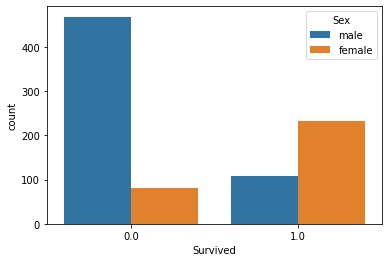

In [4]:
sns.countplot(x='Survived', hue='Sex', data=df_whole)


More men died than women, and there were significantly less survivors than those who survived

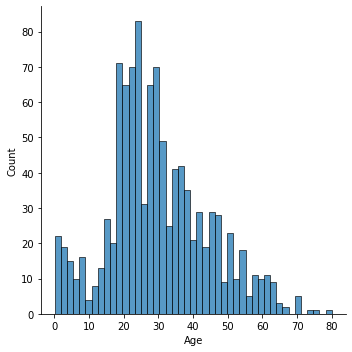

In [5]:
sns.displot(df_whole['Age'].dropna(), kde=False, bins = 45)

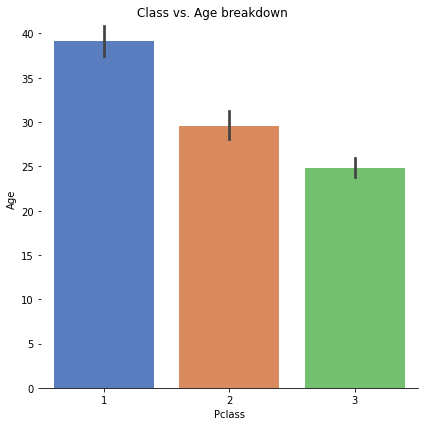

In [6]:
# Draw a nested barplot to show Age breakdown for differetn classes
# https://stackoverflow.com/questions/60237979/python-and-seaborn-how-to-plot-
# two-categorical-features-using-barplot
g = sns.catplot(x="Pclass", y="Age", hue=None, data = df_whole,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.fig.suptitle("Class vs. Age breakdown")
g.set_ylabels("Age")

Seems like a lot of 20s and 30s year old were on the boat. Additionally, there were more young children compared to old folk

## Data Cleaning and Adhering to Assumptions

In [7]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Going to deal with Age first, trying to modify it to replace the missing values with age. Chose to split it by class becuase assuming that each age group aligns with different classes. 

In [8]:
print(df_whole.groupby('Pclass').mean()['Age'])

# replacing each class's empty age values with the respective means
def fill_age(cols):
    Age = cols['Age']
    Pclass = cols['Pclass']  
    if pd.isnull(Age):
        if Pclass == 1:
            return 39
        elif Pclass == 2:
            return 30
        else:
            return 25
    else:
        return Age

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64


In [9]:
df_tests = df_whole.copy()
df_whole['Age'] = df_whole[['Age', 'Pclass']].apply(fill_age, axis = 1)

# age handled, Fare and Embarked has missing data, Cabin is 
# missing a lot of 
#data so we drop it as well as Ticket as ticket correlates 
# with other possible
# features
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [10]:
df_whole.drop(['Cabin', 'Ticket'], axis=1, inplace=True)
df_whole.groupby('Pclass').mean()['Fare']

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [11]:
print(df_whole[df_whole['Fare'].isnull()])
print(df_whole[df_whole['Embarked'].isnull()])

      PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

      Parch  Fare Embarked  
1043      0   NaN        S  
     PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Fare Embarked  
61   female  38.0      0      0  80.0      NaN  
829  female  62.0      0      0  80.0      NaN  


In [12]:
# replacing null fare for passenger with the average fare 
# for respective class
df_whole.loc[df_whole['PassengerId'] == 1044, 'Fare'] = 13.302889

# replacing null embarked status with 'C' for two passengers
df_whole.loc[df_whole['PassengerId'].isin([62, 830]), 'Embarked'] = 'C'
df_whole.loc[df_whole['PassengerId'].isin([62, 830])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,C
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,C


In [13]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Fare         1309 non-null   float64
 9   Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 102.4+ KB


In [14]:
gender = pd.get_dummies(df_whole['Sex'], drop_first=True)
print(gender.head())
embarked = pd.get_dummies(df_whole['Embarked'], drop_first=True)
print(embarked.head())

df_whole = pd.concat([df_whole, gender, embarked], axis = 1)
df_whole.drop(['Sex', 'Embarked'], axis = 1, inplace=True)
df_whole.head()

   male
0     1
1     0
2     0
3     0
4     1
   Q  S
0  0  1
1  0  0
2  0  1
3  0  1
4  0  1


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Q,S
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,1,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,1,0,1


In [15]:
# dropping unneccessary identifiers 
df_whole.drop(['Name', 'PassengerId'], axis=1, inplace=True)
df_whole

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0.0,3,22.0,1,0,7.2500,1,0,1
1,1.0,1,38.0,1,0,71.2833,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,0,1
3,1.0,1,35.0,1,0,53.1000,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,25.0,0,0,8.0500,1,0,1
1305,NaN,1,39.0,0,0,108.9000,0,0,0
1306,NaN,3,38.5,0,0,7.2500,1,0,1
1307,NaN,3,25.0,0,0,8.0500,1,0,1


In [16]:
# splitting data

df_train_alt = df_whole[:891]
df_test_alt = df_whole[891:]

X = df_train_alt.drop('Survived', axis=1)
y = df_train_alt['Survived']

df_whole.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0.0,3,22.0,1,0,7.2500,1,0,1
1,1.0,1,38.0,1,0,71.2833,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,0,1
3,1.0,1,35.0,1,0,53.1000,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,0,1


## Logistic Regression

### Preliminary Classification Report

In [17]:
# getting initial scores on what we might see 
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
# https://scikit-learn.org/stable/modules/preprocessing.html
#https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
skf = StratifiedKFold(n_splits=3)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)  # apply scaling on training data
    #logmodel.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       183
         1.0       0.75      0.69      0.72       114

    accuracy                           0.79       297
   macro avg       0.79      0.78      0.78       297
weighted avg       0.79      0.79      0.79       297

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       183
         1.0       0.75      0.74      0.74       114

    accuracy                           0.80       297
   macro avg       0.79      0.79      0.79       297
weighted avg       0.80      0.80      0.80       297

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85       183
         1.0       0.81      0.67      0.73       114

    accuracy                           0.81       297
   macro avg       0.81      0.78      0.79       297
weighted avg       0.81      0.81      0.81       297



In [18]:

X_test = df_test_alt.drop('Survived', axis=1)
pipe_log = make_pipeline(StandardScaler(), LogisticRegression())
pipe_log.fit(X, y)  # apply scaling on training data
    #logmodel.fit(X_train, y_train)
predictions_log_reg = pipe_log.predict(X_test)

print(predictions_log_reg.size)


418


### Helper Methods for Graphing

In [19]:
# to iterate different colors
cycol = cycle('bgrcmk')

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.
# precision_recall_curve.html
# https://stackoverflow.com/questions/61230590/
# what-is-estimated-probabilityprobas-pred-in-sklearn-metrics-precision
# -recall-c

def showPrecisionRecallGraph(pipe): 
    # getting the probabilities of our predictions
    y_scores = pipe.predict_proba(X)
    y_scores = y_scores[:,1]

    precision, recall, threshold = precision_recall_curve(y, y_scores)

    plt.figure(figsize=(15, 7))
    plt.plot(threshold, precision[:-1], next(cycol), 
             label="Precision", linewidth = 5)
    plt.plot(threshold, recall[:-1], next(cycol), label="Recall", 
             linewidth = 5)
    plt.xlabel("Threshold", fontsize=15)
    plt.legend(loc="lower left", fontsize=15)
    plt.ylim([0, 1])

    plt.show()



In [20]:

def showROCCurve(pipe): 
    # getting the probabilities of our predictions
    y_scores = pipe.predict_proba(X)
    y_scores = y_scores[:,1]
    
    # calculate true positive rate and false positive rate
    fpr, tpr, thresholds = \
    roc_curve(y, y_scores)

    plt.plot(fpr, tpr, linewidth = 5, label = None)
    plt.plot([0, 1], [0, 1], next(cycol), linewidth = 5)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rates (FPR)', fontsize = 15)
    plt.ylabel('True Positive Rates (TPR)', fontsize = 15)

    plt.figure(figsize=(15, 7))
    plt.show()


In [21]:
def showPrecisionRecallScores(pipe):
    predictions = cross_val_predict(pipe, X, y, cv = 3)
    print("Precision: ", precision_score(y, predictions))
    print("Recall: ",recall_score(y, predictions))

### Precision, Recall, & ROC Graphs

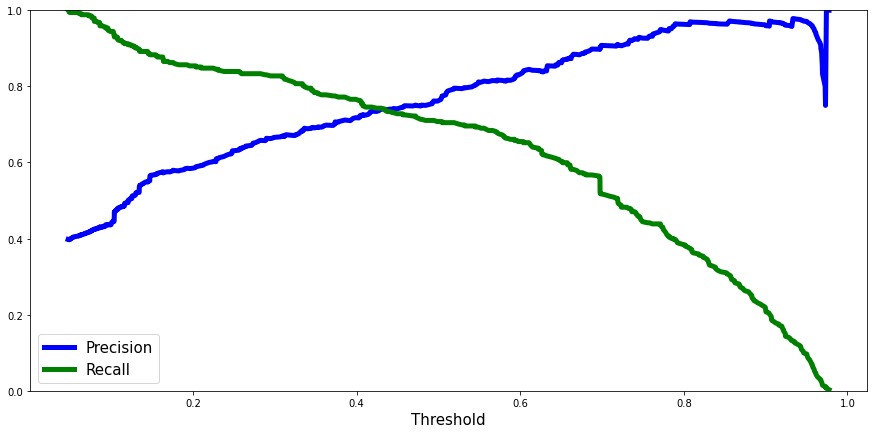

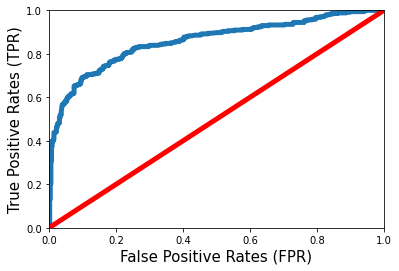

<Figure size 1080x504 with 0 Axes>

Precision:  0.7684887459807074
Recall:  0.6988304093567251


In [22]:
showPrecisionRecallGraph(pipe_log)
showROCCurve(pipe_log)
showPrecisionRecallScores(pipe_log)

There seems to be a little drop off once our threshold reaches closer to 1.0
Also, the optimal threshold of .80. The Precision score is doing well as the model predicts correctly 76% of the time. While our recall score is okay as it 69% correctly predicted actually those who survived. 

In [23]:
df_predictions_log_reg = pd.DataFrame({'PassengerID' : ids, 
                        'Survived' : predictions_log_reg.astype(int)})
df_predictions_log_reg.to_csv('log_reg_submission.csv', index=False)

## QuadraticDiscriminantAnalysis

### Classification Report

In [24]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe_qda = make_pipeline(StandardScaler(), 
                             QuadraticDiscriminantAnalysis())
    pipe_qda.fit(X_train, y_train)  # apply scaling on training data
    
    predictions_qda = pipe_qda.predict(X_test)
    
    print(classification_report(y_test, predictions_qda))

              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       183
         1.0       0.68      0.56      0.62       114

    accuracy                           0.73       297
   macro avg       0.72      0.70      0.70       297
weighted avg       0.73      0.73      0.72       297

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.83       183
         1.0       0.73      0.72      0.73       114

    accuracy                           0.79       297
   macro avg       0.78      0.78      0.78       297
weighted avg       0.79      0.79      0.79       297

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       183
         1.0       0.77      0.67      0.71       114

    accuracy                           0.79       297
   macro avg       0.79      0.77      0.78       297
weighted avg       0.79      0.79      0.79       297



In [25]:
X_test = df_test_alt.drop('Survived', axis=1)

pipe_qda = make_pipeline(StandardScaler(),QuadraticDiscriminantAnalysis())
pipe_qda.fit(X, y)  # apply scaling on training data
predictions_qda = pipe_qda.predict(X_test)

#predictions_qda


### Precision, Recall, & ROC Graphs

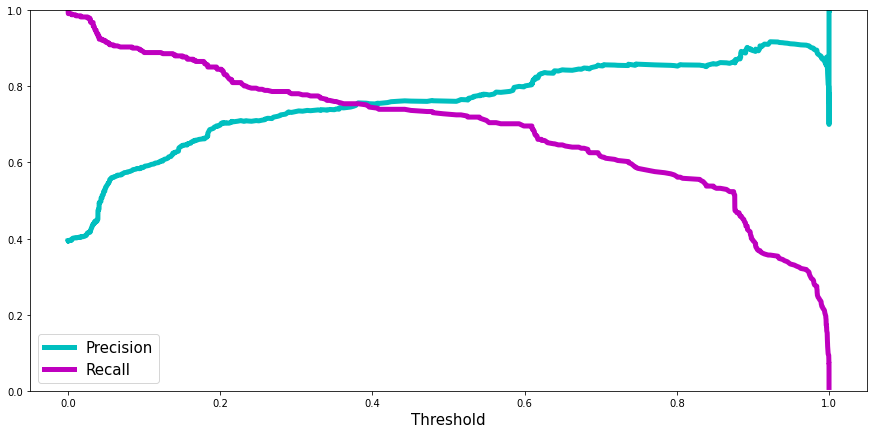

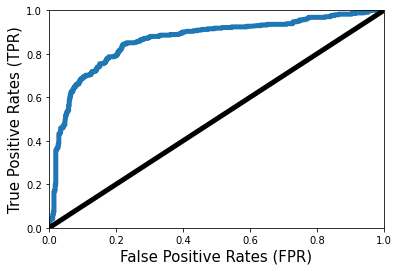

<Figure size 1080x504 with 0 Axes>

Precision:  0.7278688524590164
Recall:  0.6491228070175439


In [26]:
showPrecisionRecallGraph(pipe_qda)
showROCCurve(pipe_qda)
showPrecisionRecallScores(pipe_qda)

Quadratic did worse in comparison to logistic. It indicates which scaling is preferible. Interesting to see how it fares in the Kaggle hidden test cases. 

In [27]:
df_predictions_qda = pd.DataFrame({'PassengerID' : ids, 
                        'Survived' : predictions_qda.astype(int)})
df_predictions_qda.to_csv('quadratic_submission.csv', index=False)

## K- nearest neighbors

### Classification Report

In [28]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe_knn = make_pipeline(StandardScaler(), 
                             KNeighborsClassifier(n_neighbors = 5))
    pipe_knn.fit(X_train, y_train)  # apply scaling on training data
    
    predictions_knn = pipe_knn.predict(X_test)
    
    print(classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       183
         1.0       0.77      0.66      0.71       114

    accuracy                           0.79       297
   macro avg       0.79      0.77      0.78       297
weighted avg       0.79      0.79      0.79       297

              precision    recall  f1-score   support

         0.0       0.86      0.81      0.84       183
         1.0       0.73      0.79      0.76       114

    accuracy                           0.80       297
   macro avg       0.79      0.80      0.80       297
weighted avg       0.81      0.80      0.81       297

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86       183
         1.0       0.82      0.67      0.73       114

    accuracy                           0.81       297
   macro avg       0.82      0.79      0.80       297
weighted avg       0.82      0.81      0.81       297



In [29]:
# chose 5 as number of neighbors as it offered the smoothest curve 
# and highest
# precision from above
X_test = df_test_alt.drop('Survived', axis=1)
pipe_knn = make_pipeline(StandardScaler(), 
                         KNeighborsClassifier(n_neighbors = 5))
pipe_knn.fit(X, y)  # apply scaling on training data
predictions_knn = pipe_knn.predict(X_test)
                         



### Precision, Recall, & ROC Graphs

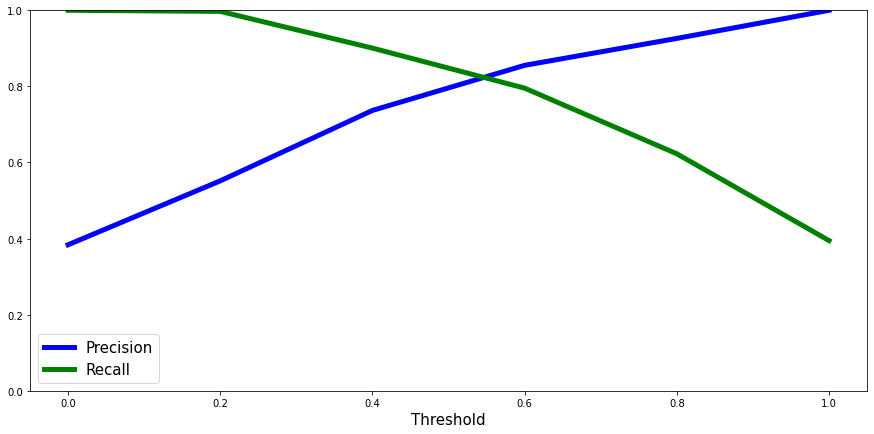

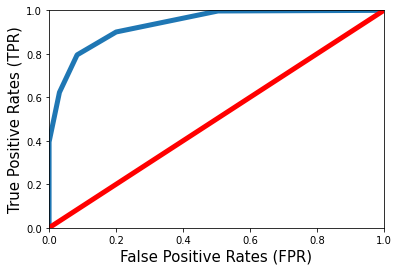

<Figure size 1080x504 with 0 Axes>

Precision:  0.767515923566879
Recall:  0.7046783625730995


In [30]:
showPrecisionRecallGraph(pipe_knn)
showROCCurve(pipe_knn)
showPrecisionRecallScores(pipe_knn)

As expected, the score is the best out of the three models as this model is better suited for many features. Multiclass/multilabel classification is what KNN is best for. This score will do the best amongst the other models in the Kaggle hidden test cases. 

In [31]:
df_predictions_knn = pd.DataFrame({'PassengerID' : ids, 
                             'Survived' : predictions_knn.astype(int)})
df_predictions_knn.to_csv('knn_submission.csv', index=False)